Code adapted from: https://github.com/Garima13a/MNIST_GAN/blob/master/MNIST_GAN_Solution.ipynb


The idea behind GANS is that you have two networks, a generator G and a discriminator D, competing against each other. THe generator makes "fake" data to pass to the discriminator. Whilst the discriminator also sees real trianing data and predicts if the data it's received is real or fake. 

The generator is trained to fool the discriminator, it wants to output data that looks as close as possible to real, training data. 

The discriminator is a classifier that is trained to figure out which data is real and which if fake. 

The generator learns to make data that is indistinguishable from real data to the discriminator. 

In [33]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

In [34]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

#convert data to torch.FloatTensor
transform = transforms.ToTensor()

#get the training datasets
train_data = datasets.MNIST(root='data', train=True, 
                            download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers)

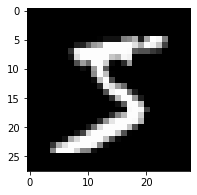

In [35]:
#Visualising the data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# Define the model

Discriminator
The discriminator network is going to be a typical linear classifier. This will need at least one hidden layer, and these hiden layers should have one key attribute: all hidden layers will have a Leaky ReLu activation function applied to their outputs.

**Leaky ReLu**
A leaky ReLu allows gradients to flow backwards through the layer unimpeded. A leaky ReLu is like a normal ReLu, except that there is a small non-zero output for negative input values.

**Sigmoid Output**
We'll also take the approach of using a mroe numerically stable loss function on the outputs. We want the discriminator to output a value 0-1 indicating whether an image is real or fake.

The BCEWithLogitsLoss combines the sigmoid acitvation function and binary cross entropy loss in one function.


In [36]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Discriminator, self).__init__()

    #define hidden linear layers
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)

    #final fully connected layer
    self.fc4 = nn.Linear(hidden_dim, output_size)

    # dropout layer
    self.dropout = nn.Dropout(0.3)

  def forward(self,x):
    #flatten image
    x = x.view(-1, 28*28)
    # all hidden layers
    x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope =0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    #final layer
    out = self.fc4(x)

    return out 

#Generator
The Generator network is almost exactly the same as the discriminator, but instead a tahn activation function is applied instead to the output layer.

Tahn output
The generator has been found to perform the best with tanh for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1.

We want these outputs to be comparable to real input pixel values, which are read in as normalized values between 0 and 1.

So we'll have to scale our real input images to have pixel values vetween -1 and 1, when we want to train the discriminator.

In [37]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

#Model Hyperparameters

In [38]:
# Discriminator Hyperparams

#Size of input image to discriminator (28*28)
input_size = 784
#Size of discriminator output (real or fake)
d_output_size = 1
#Size of last hidden layer in the discriminator
d_hidden_size = 32

#Generator hyperparams

# SIze of latent vector to give to generator
z_size = 100
#Size of discriminator output (generated image)
g_output_size = 784
#Size of first hidden layer in the generator
g_hidden_size = 32

#Build Complete Network


In [39]:
# Instantiate discriminator and generator 
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

#check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#Discriminator and Generator Losses

**Discriminator Losses**
For the discriminator, the toal loss ithe sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss

- We want the discriminator to output 1 for real images, and 0 for fake images, so we need to set up the losses to reflect that

The lossess will be binary cross entropy loss with logits, which we can get with BCEWithLogitsLoss, which combines sigmoid activation and binary cross entropy loss in one function.

For the real images, we want D(real_images) = 1. That is , we want the discriminator to classify the real images iwth a label = 1. Indicating that these are real.

To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9 - for these we'll use the parameter smooth; if True, then we should smooth our labels. In PyTorch this looks like: labels = torch.ones(size) * 0.9

**Generator Loss**

The generator loss will look similar, only with flipped labels. the generator's goal is to get D(fake_images) = 1. In this case the labels are flipped to represent the generator is trying to foool the discriminator into thinking that the images it generates are real.

In [40]:
#Calculate losses
def real_loss(D_out, smooth=False):
  batch_size = D_out.size(0)
  #label smoothing 
  if smooth:
    #smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size) #real labels = 1

  #numerically stable loss
  criterion = nn.BCEWithLogitsLoss()
  #Calculate loss
  loss = criterion(D_out.squeeze(),labels)
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size) # fake lebels = 0 
  criterion = nn.BCEWithLogitsLoss()
  #calculate loss
  loss = criterion(D_out.squeeze(), labels)
  return loss

#Optimizers

We want to update the generator and discriminator variables separately, so we'll define two separate Adam optimizers

In [41]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimimzers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)



#Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions, real_loss and fake_loss to help us calculate the discriminator losses in all of the following cases. 

**Discriminator Training**
1. Compute the discriminator loss on real, training images
2. Generate Fake images
3. Compute the discriminator loss on fake, generated imges
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights.

**Generator Training**
1. Generate fake images
2. Compute the discriminator loss on fake images, using flipped labels.
3. Perform backpropagation + an optimization step to update the generator's weights 

**Saving Samples**


In [42]:
import pickle as pkl 

#training hyperparams
num_epochs = 100

#keep track of loss and genrated, "fake" samples
samples = []
losses = []

print_every = 400

#Get some fixed data for sampling. These are images that are held constant 
# throughout training, and allow us to inspect the model's performance

sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Train the network
D.train()
G.train()
for epoch in range(num_epochs):
  
  for batch_i, (real_images, _) in enumerate(train_loader):

    batch_size = real_images.size(0)

    ## Important rescaling step
    real_images = real_images*-1 #rescale input images from [0,1] to [-1,1]

      
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

    d_optimizer.zero_grad()

    # 1. Train with real images

    # Compute the discriminator losses on real images
    #Smooth the real labels
    D_real = D(real_images)
    d_real_loss = real_loss(D_real, smooth=True)

    #2. Train with fake images

    #Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)

    #compute the discriminator losses on fake images

    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake) 

    #add up loss and perform backprop

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step() 

         
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================

    # 1. Train with fake images and flipped labels

    #Generate fake images
    z = np.random.uniform(-1,1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)

    #Compute the discriminator losses on fake images
    #Using flipped labels
    D_fake = D(fake_images)
    g_loss = real_loss(D_fake) # use real loss to flip labels

    #perform backprop
    g_loss.backward()
    g_optimizer.step() 

    #print some loss stats
    if batch_i % print_every == 0:
      #print discriminator and generator loss 

      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3833 | g_loss: 0.7376
Epoch [    1/  100] | d_loss: 0.3401 | g_loss: 35.3111
Epoch [    1/  100] | d_loss: 0.3370 | g_loss: 47.5880
Epoch [    2/  100] | d_loss: 0.3372 | g_loss: 58.8740
Epoch [    2/  100] | d_loss: 0.3305 | g_loss: 62.8968
Epoch [    2/  100] | d_loss: 0.3279 | g_loss: 166.0043
Epoch [    3/  100] | d_loss: 0.3286 | g_loss: 154.1114
Epoch [    3/  100] | d_loss: 0.3279 | g_loss: 150.6368
Epoch [    3/  100] | d_loss: 0.3271 | g_loss: 129.0744
Epoch [    4/  100] | d_loss: 0.3273 | g_loss: 138.4198
Epoch [    4/  100] | d_loss: 0.3272 | g_loss: 129.0678
Epoch [    4/  100] | d_loss: 0.3269 | g_loss: 119.7284
Epoch [    5/  100] | d_loss: 0.3261 | g_loss: 123.6517
Epoch [    5/  100] | d_loss: 0.3257 | g_loss: 84.0022
Epoch [    5/  100] | d_loss: 0.3261 | g_loss: 162.9735
Epoch [    6/  100] | d_loss: 0.3259 | g_loss: 116.5309
Epoch [    6/  100] | d_loss: 0.3257 | g_loss: 108.0996
Epoch [    6/  100] | d_loss: 0.3255 | g_loss: 87.8456


KeyboardInterrupt: ignored

#Training Loss

Plotting Training losses for the gneerator and the discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

#Generator samples from training

Viewing samples of images from the generator - firs tlooking at the images we saved during training.

In [43]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

In [ ]:
# Showing the generated images as network was training, every 10 epochs

rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

#Sampling from the generator

We can get completely new images from the generator by using the checkpoint we saved after training, we just need to pass in a new latent vector z, and we'll get new samples.

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])
